<a href="https://colab.research.google.com/github/sayanbanerjee32/TSAI_ERAv2_S7/blob/main/step2/S7_step2_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Add Regularization - Dropout
- Start transition block at receptive field 5
- Increase model capacity. Add more layers at the end.

## Results:

- Parameters: 7432
- Best Training Accuracy: 98.89%
- Best Test Accuracy: 99.19%

## Analysis:

- Model does not show any overfitting, however able to reach 99% accuracy consistently
- Test loss is flactuating towards end epochs. Thus use of LR scheduler might be helpful
- Adding image augmentation for training set might be hlpful in pushing Test accuracy further.

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

#import from local modules
from model_2 import Net
from utils import train, test, get_device, plot_accuracy_losses

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Train and Test transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [4]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 111836019.44it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37772277.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31921070.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23175825.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 1, 28, 28])
torch.Size([128])


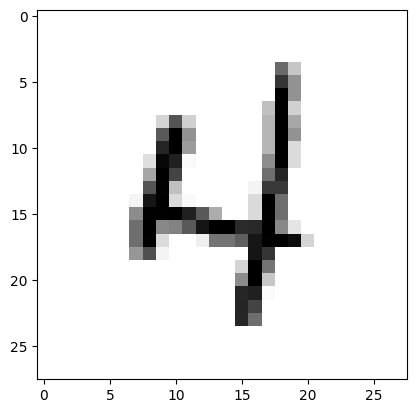

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

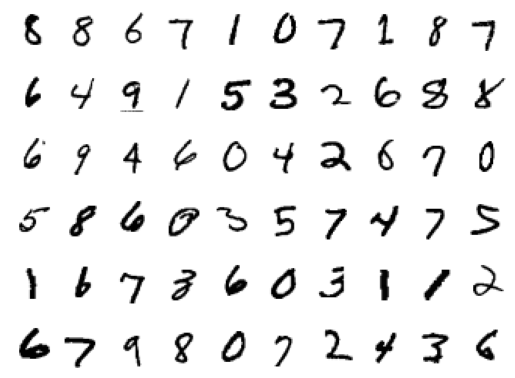

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Training

In [11]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)




Epoch 1


Train: Loss=0.1470 Batch_id=468 Accuracy=83.15: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]


Test set: Average loss: 0.1728, Accuracy: 9527/10000 (95.27%)

Epoch 2


Train: Loss=0.0970 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]


Test set: Average loss: 0.0787, Accuracy: 9786/10000 (97.86%)

Epoch 3


Train: Loss=0.0702 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]


Test set: Average loss: 0.0592, Accuracy: 9826/10000 (98.26%)

Epoch 4


Train: Loss=0.0174 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]


Test set: Average loss: 0.0495, Accuracy: 9854/10000 (98.54%)

Epoch 5


Train: Loss=0.0325 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]


Test set: Average loss: 0.0534, Accuracy: 9833/10000 (98.33%)

Epoch 6


Train: Loss=0.0841 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]


Test set: Average loss: 0.0464, Accuracy: 9857/10000 (98.57%)

Epoch 7


Train: Loss=0.0726 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Test set: Average loss: 0.0309, Accuracy: 9912/10000 (99.12%)

Epoch 8


Train: Loss=0.0373 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]


Test set: Average loss: 0.0339, Accuracy: 9895/10000 (98.95%)

Epoch 9


Train: Loss=0.0465 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]


Test set: Average loss: 0.0321, Accuracy: 9904/10000 (99.04%)

Epoch 10


Train: Loss=0.0107 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]


Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

Epoch 11


Train: Loss=0.0195 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]


Test set: Average loss: 0.0285, Accuracy: 9905/10000 (99.05%)

Epoch 12


Train: Loss=0.1196 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]


Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

Epoch 13


Train: Loss=0.0465 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]


Test set: Average loss: 0.0267, Accuracy: 9919/10000 (99.19%)

Epoch 14


Train: Loss=0.0180 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]


Test set: Average loss: 0.0301, Accuracy: 9910/10000 (99.10%)

Epoch 15


Train: Loss=0.0357 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]


Test set: Average loss: 0.0283, Accuracy: 9903/10000 (99.03%)



## Visualise training and test losses and accuracies

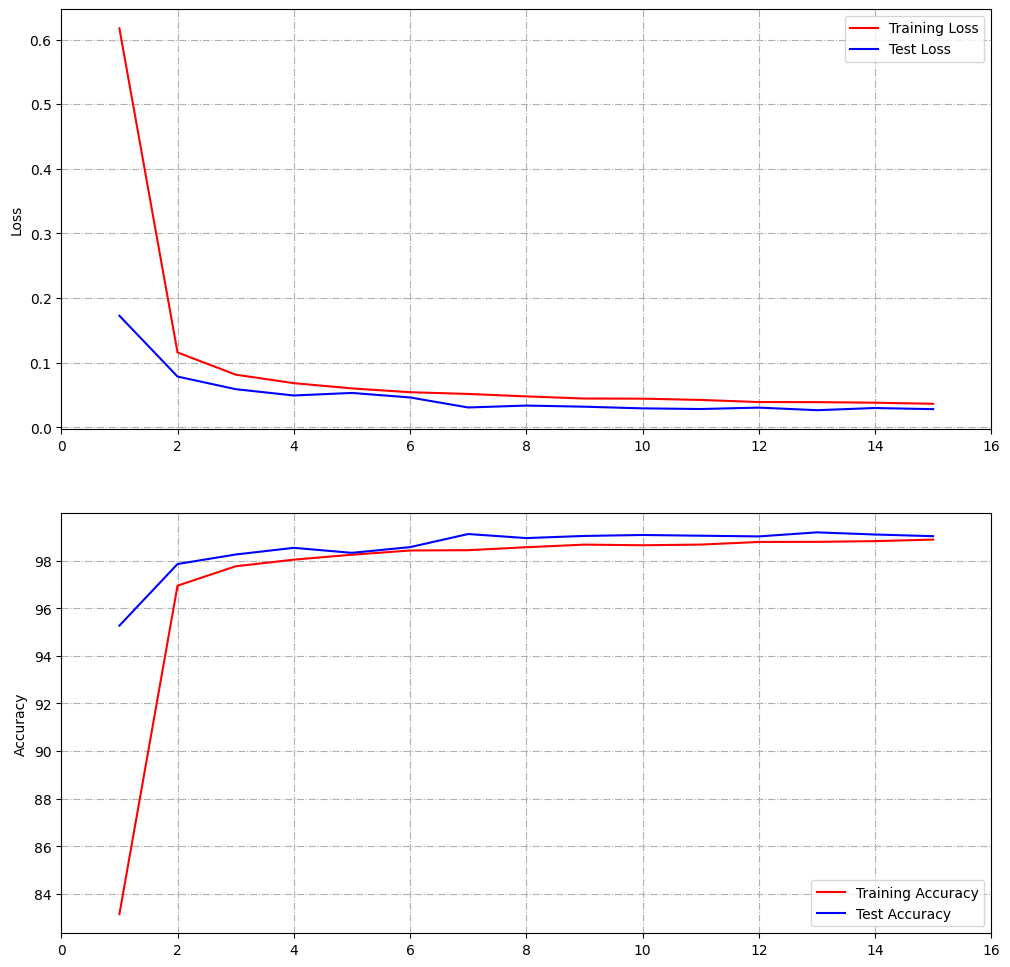

In [14]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs)